In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import csv

import numpy as np
import random
import time

from sklearn.preprocessing import StandardScaler, MinMaxScaler


import sys
sys.path.insert(0, "../utils/")
import utils as ut

import tensorflow as tf
import matplotlib.pyplot as plt

import keras
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError

from keras import backend as K

## Input options

In [3]:
features_names   = ['m1', 'm2', 's1x', 's1y', 's1z', 's2x', 's2y', 's2z', 'theta', 'q', 'Mc'];
regr_data_dir    = '../NewRealistic/'
write_output     = False
out_data_dir     = '../NNtf_results/'
versions         = ['0'] # can be a subset of ['0', '1', '2']
clabels          = ['0'] # can be a subset of ['0', '1'] 

# training options
remove_some_mass = False
epochs           = 250
validation_split = 0.1
batch_size       = 128
verbose_training = 0
hlayers_sizes    = [100, 100];
learning_rate    = 0.0001
scaler_type      = 'mixed'  # standard, minmax, mixed
activation       = 'relu'
out_activation   = 'linear_cut_mod' # sigmoid, linear, linear_cut, linear_cut_T3, linear_cut_lb, linear_cut_mod

## Check on input and dictionary-initialization

In [4]:
# define dictionary for each version considered
Nv       = len(versions)
Nc       = len(clabels)
Nsets    = Nv*Nc

if Nv*Nc!=Nsets:
    print('+++ Wrong input! +++')

datasets = {}
keys     = []
for i in range(0,Nv):
    version = versions[i]
    for j in range(0,Nc):
        clabel = clabels[j]
        key = 'v'+version+'c'+clabel
        keys.append(key)
        datasets[key]         = lambda:0
        datasets[key].clabel  = clabel
        datasets[key].version = version

In [5]:
# define all the ouput activation functions
def output_activation_sigmoid(x):
    return K.sigmoid(x)*2-1

def output_activation_linear(x):
    return x

def output_activation_linear_cut(x):
    signs = K.switch(x>0, 1+x*0, -1+x*0) # x*0 in order to broadcast to correct dimension
    return K.switch(abs(x)<1, x, signs)

def output_activation_linear_cut_T3(x):
    return 2/(K.exp(-(2*x+2/3*x*x*x))+1)-1

def output_activation_linear_cut_lb(x):
    return K.switch(x>-1, x, -1+x*0)

# define model using Functional API
def buildModelUsingFunctionalAPI(hlayers_sizes, batch_size, Nfeatures, out_activation='linear'):
    model_input = keras.Input(shape=(Nfeatures))
    x = Dense(hlayers_sizes[0], kernel_initializer='normal', activation=activation)(model_input)
    for i in range(1, len(hlayers_sizes)):
        x = Dense(hlayers_sizes[i], kernel_initializer='normal', activation=activation)(x)
    
    if out_activation=="sigmoid":
        out = Dense(Nfeatures, kernel_initializer='normal',\
                    activation=output_activation_sigmoid)(x)
    
    elif out_activation=="linear":
        out = Dense(Nfeatures, kernel_initializer='normal',\
                    activation=output_activation_linear)(x)
        
    elif out_activation=="linear_cut":
        out = Dense(Nfeatures, kernel_initializer='normal',\
                    activation=output_activation_linear_cut)(x)    
    
    elif out_activation=="linear_cut_T3":
        out = Dense(Nfeatures, kernel_initializer='normal',\
                    activation=output_activation_linear_cut_T3)(x)
    
    elif out_activation=="linear_cut_lb":
        out = Dense(Nfeatures, kernel_initializer='normal',\
                    activation=output_activation_linear_cut_lb)(x)
    
    elif out_activation=="linear_cut_mod":
        if Nfeatures==11:
            neuronsA = 2 # m1, m2
            neuronsB = 7 # s1,s2,theta
            neuronsC = 2 # q, Mc
        elif Nfeatures==9:
            neuronsA = 1 # m1
            neuronsB = 7 # s1,s2,theta
            neuronsC = 1 # Mc
        else:
            print("'linear_cut_mod' is hardcoded for Nfeatures=9,11!")
            sys.exit()
        branchA = Dense(neuronsA, kernel_initializer='normal', activation=output_activation_linear_cut_lb)(x)
        branchB = Dense(neuronsB, kernel_initializer='normal', activation=output_activation_linear_cut)(x)
        branchC = Dense(neuronsC, kernel_initializer='normal', activation=output_activation_linear_cut_lb)(x)
        out = tf.keras.layers.concatenate([branchA, branchB, branchC])

    return keras.Model(model_input, out)

mse = MeanSquaredError()

## Loop on versions

********************************************************************************
Key: v0c0
********************************************************************************
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 11)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 100)          1200        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 100)          10100       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)     

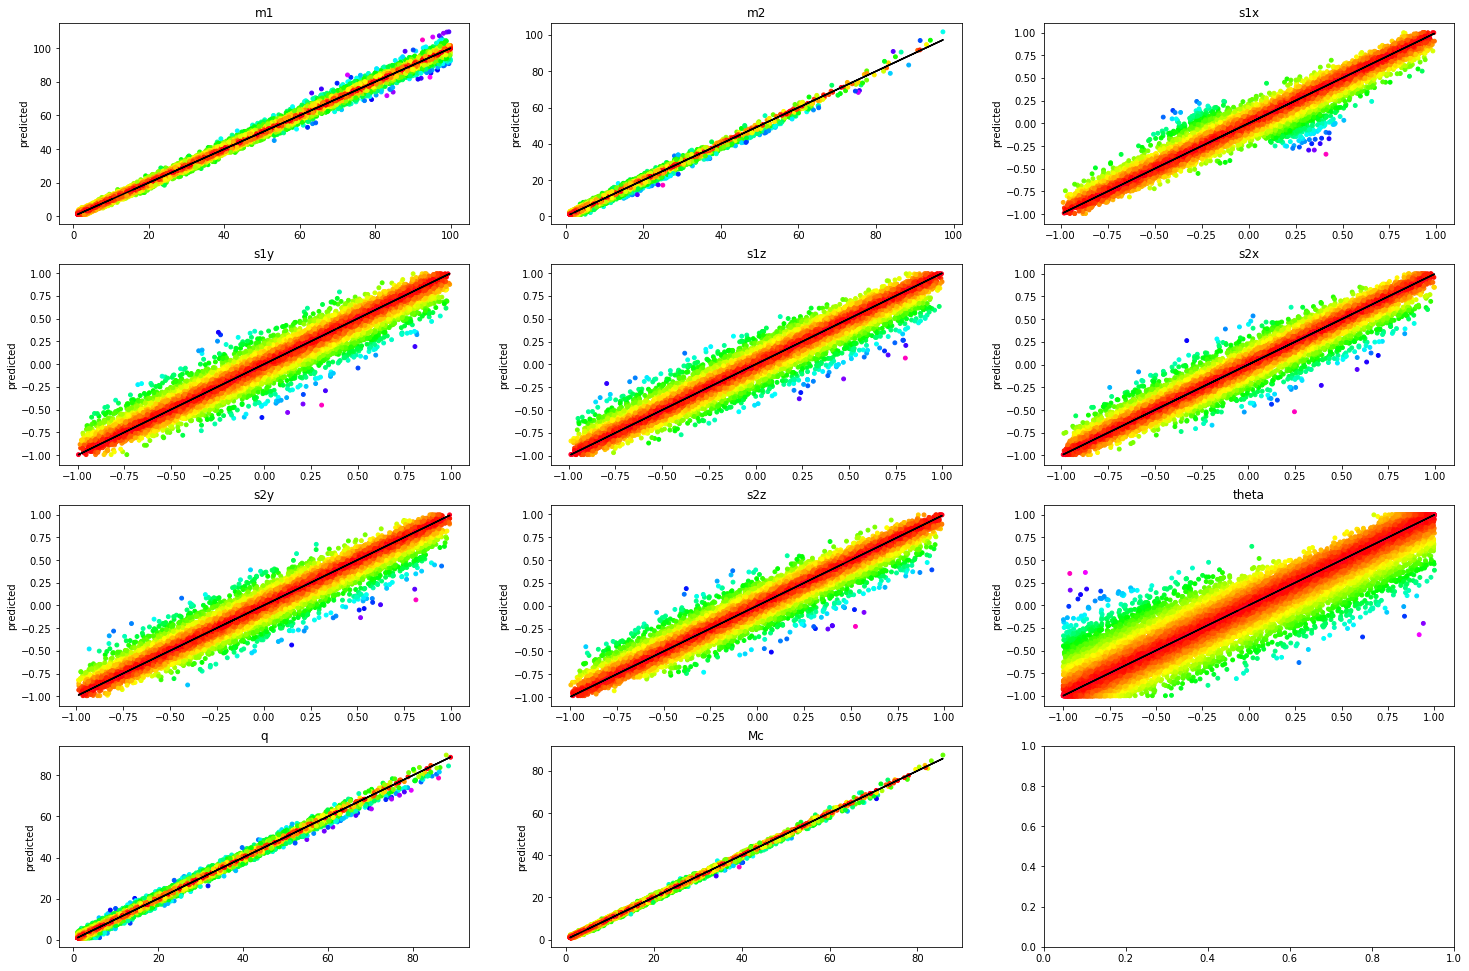

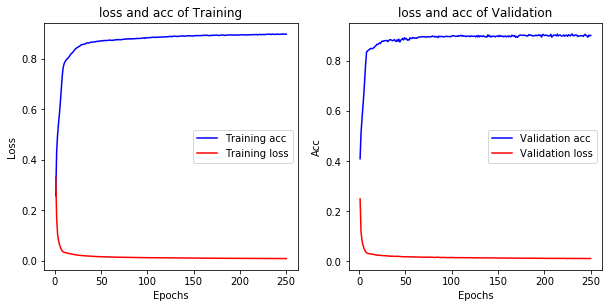

In [6]:
dashes = '*'*80

for key in keys:
    print(dashes, '\nKey: ', key, '\n', dashes, sep='')
    
    data_paths = {}
    data_paths['xtrain'] = regr_data_dir+key+'train_x.csv'
    data_paths['ytrain'] = regr_data_dir+key+'train_y.csv'
    data_paths['xtest']  = regr_data_dir+key+'test_x.csv'
    data_paths['ytest']  = regr_data_dir+key+'test_y.csv'

    rdl_out = ut.regressionDatasetLoader(data_paths, features_names,
                           scaler_type=scaler_type,
                           remove_some_mass=remove_some_mass)
    
    xtrain   = rdl_out['xtrain']
    ytrain   = rdl_out['ytrain']
    xtest    = rdl_out['xtest']
    ytest    = rdl_out['ytest']
    scaler_x = rdl_out['scaler_x']
    scaler_y = rdl_out['scaler_y']
    labels   = rdl_out['labels']
    
    Nfeatures = len(xtrain[0,:])
    
    # build, compile and train the model
    model = buildModelUsingFunctionalAPI(hlayers_sizes, batch_size, Nfeatures, out_activation=out_activation)
    model.compile(
        loss=mse, 
        optimizer=Adam(learning_rate=learning_rate), 
        metrics=[mse, 'accuracy']
    )
    model.summary()
    t0 = time.perf_counter()
    history = model.fit(xtrain, ytrain, 
        epochs           = epochs, 
        batch_size       = batch_size,
        validation_split = validation_split,
        verbose          = verbose_training
    )
    train_time = time.perf_counter()-t0
    
    # predict
    ypredicted = model.predict(xtest)
    
    # print some information
    metrics_dict = ut.evalutationMetricsDict(xtest,ytest,model)
    ut.printMetrics(metrics_dict)

    # update dictionary adding data (both normalized and not), model and score
    datasets[key].train_time = train_time
    datasets[key].model      = model
    datasets[key].history    = history
    datasets[key].predicted  = scaler_y.inverse_transform(ypredicted)
    datasets[key].metrics    = metrics_dict
    datasets[key].Ntrain     = len(xtrain[:,0])
    
    # plot
    ut.predictionPlots(ytest, ypredicted, labels, scaler=scaler_y)
    
    del model
    
    ut.plotHistory(history)

## Produce CSV files

In [7]:
if write_output:
    for key in keys:
        # save csv
        filename = out_data_dir+'NN_tf_'+key+'.csv'
        ut.writeResult(filename, datasets[key].predicted, verbose=True)
        
        # save model
        #dict_name = out_data_dir+'NN_tf_'+key+'.dict'
        #pickle.dump(datasets[key].model, open(dict_name, 'wb'))
        #print(dict_name, 'saved') 
        
        # example for loading models
        #dict_name    = out_data_dir+'NN_tf_'+key+'.dict'
        #print('Loading', dict_name, '...')
        #loaded_model = pickle.load(open(dict_name, 'rb'))